# Introduction

This is where my plans for the air quality index (AQI) prediction service are. With any coding project larger than a simple script, things can quickly get out of hand if careful planning isn't carried out before starting to code.

This project was born from an idea I found on [Twitter](https://datamachines.xyz/2022/11/22/build-a-prediction-service-with-machine-learning-step-by-step/) by Pau Labarta Bajo. At the link, he gives a short outline of the steps needed to complete the project. The steps are vague enough to warrant some serious learning by those who are not familiar with deploying machine learning models (me), but just detailed enough to know the rough path to take. This is a great departure from tutorials where you mindlessly watch someone code X project and then claim you've learned how to do X.

First, a quick outline of the project. The air quality index is a measure of the levels of specific pollutants in the air. Below is a table I copied from the Wikipedia page for [AQI](https://en.wikipedia.org/wiki/Air_quality_index#CAQI).

<tbody><tr>
<th>Qualitative name</th>
<th>Index or sub-index</th>
<th colspan="4">Pollutant (hourly) concentration
</th></tr>
<tr>
<th colspan="2"></th>
<th>NO<sub>2</sub> μg/m<sup>3</sup></th>
<th>PM<sub>10</sub> μg/m<sup>3</sup></th>
<th>O<sub>3</sub> μg/m<sup>3</sup></th>
<th>PM<sub>2.5</sub> (optional) μg/m<sup>3</sup>
</th></tr>
<tr>
<td>Very low</td>
<td style="background:#79bc6a;">0–25</td>
<td>0–50</td>
<td>0–25</td>
<td>0–60</td>
<td>0–15
</td></tr>
<tr>
<td>Low</td>
<td style="background:#bbcf4c;">25–50</td>
<td>50–100</td>
<td>25–50</td>
<td>60–120</td>
<td>15–30
</td></tr>
<tr>
<td>Medium</td>
<td style="background:#eec20b;">50–75</td>
<td>100–200</td>
<td>50–90</td>
<td>120–180</td>
<td>30–55
</td></tr>
<tr>
<td>High</td>
<td style="background:#f29305;">75–100</td>
<td>200–400</td>
<td>90–180</td>
<td>180–240</td>
<td>55–110
</td></tr>
<tr>
<td>Very high</td>
<td style="background:#e8416f;">&gt;100</td>
<td>&gt;400</td>
<td>&gt;180</td>
<td>&gt;240</td>
<td>&gt;110
</td></tr>
</tbody>

The objective is to train a machine learning model on historical time-series AQI data for a given city and then produce a 3-day hourly forecast of the AQI for the city. New data will be downloaded frequently and this data, along with the historical data and the forecast, will be presented in a plot in an online app. The model will be retrained once a week.

The AQI data from OpenWeather is categorized as 1-5, with 5 being the worst air quality, rather than the sub-index shown in the table above. 

## Technologies Used
---
1. Python
2. XGBoost
3. OpenWeatherAPI for air quality index data
4. Streamlit to build a simple data web app that shows the historical data and forecasted AQI, but might use Gradio and HuggingFace Spaces

## Step 1: Feature Generation

The first step is to write a script to generate the features. Our data source will be the OpenWeather API. OpenWeather has a backlog of AQI data starting from 2020 November 27. This data will be downloaded via GET request and processed by a Python script.

The script needs automatically decide whether to download all of the historical data for a given city or to only download a portion of data to augment what we already have. Feature generation will be done at training/predict time.

In short, we need the following:
1. Have a function which submits a GET request for AQI data for a given time period and location.
   * Input Parameters: start_date, end_date, latitude, longitude, aqi table name, id number to use to start index
   * Output: Pandas Dataframe of the AQI data
2. Save data.
    
I'm working with time-series data here which is much different than simple tabular data about customers or flattened images. There are things such as seasonality that can be used to do feature engineering. For the sake of the project I'm not going to get too detailed on this part.

This step is written in Python files called 1_feature_gen.py and my_functions.py. With the data downloaded and saved to my computer, let's take a look at what we're dealing with.

### Exploring the Data for Chicago

In [1]:
import datetime
import pandas as pd
import numpy as np
import os
import requests

zip_code = '60603'  # Chicago
country_code = 'US'
city = 'Chicago'

aqi_table_name = f'aqi_{city}_{zip_code}'.lower()

data_path = os.path.join('data', f'{aqi_table_name}.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path, index_col='datetime', parse_dates=True)
    start_date = df.index.max()
    start_date_id = df['id'].max()

need_cols = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi', 'lat', 'lon']
data = df[need_cols]

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18704 entries, 2020-11-27 00:00:00 to 2023-01-23 09:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co      18704 non-null  float64
 1   no      18704 non-null  float64
 2   no2     18704 non-null  float64
 3   o3      18704 non-null  float64
 4   so2     18704 non-null  float64
 5   pm2_5   18704 non-null  float64
 6   pm10    18704 non-null  float64
 7   nh3     18704 non-null  float64
 8   aqi     18704 non-null  int64  
 9   lat     18704 non-null  float64
 10  lon     18704 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 1.7 MB


In [3]:
data.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,lat,lon
datetime,,,,,,,,,,,
2020-11-27 00:00:00,410.56,1.90,41.47,7.78,4.71,9.90,15.92,1.44,2,41.8798,-87.6285
2020-11-27 01:00:00,377.18,0.72,35.99,12.52,4.65,8.53,13.40,0.97,1,41.8798,-87.6285
2020-11-27 02:00:00,347.14,0.34,31.19,16.81,4.59,7.75,11.57,0.71,1,41.8798,-87.6285
2020-11-27 03:00:00,337.12,0.27,29.47,17.88,4.53,7.76,10.98,0.64,1,41.8798,-87.6285
2020-11-27 04:00:00,337.12,0.31,29.47,16.63,4.65,8.20,11.27,0.64,1,41.8798,-87.6285


In [4]:
# no missing values
data.isna().sum()

co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
aqi      0
lat      0
lon      0
dtype: int64

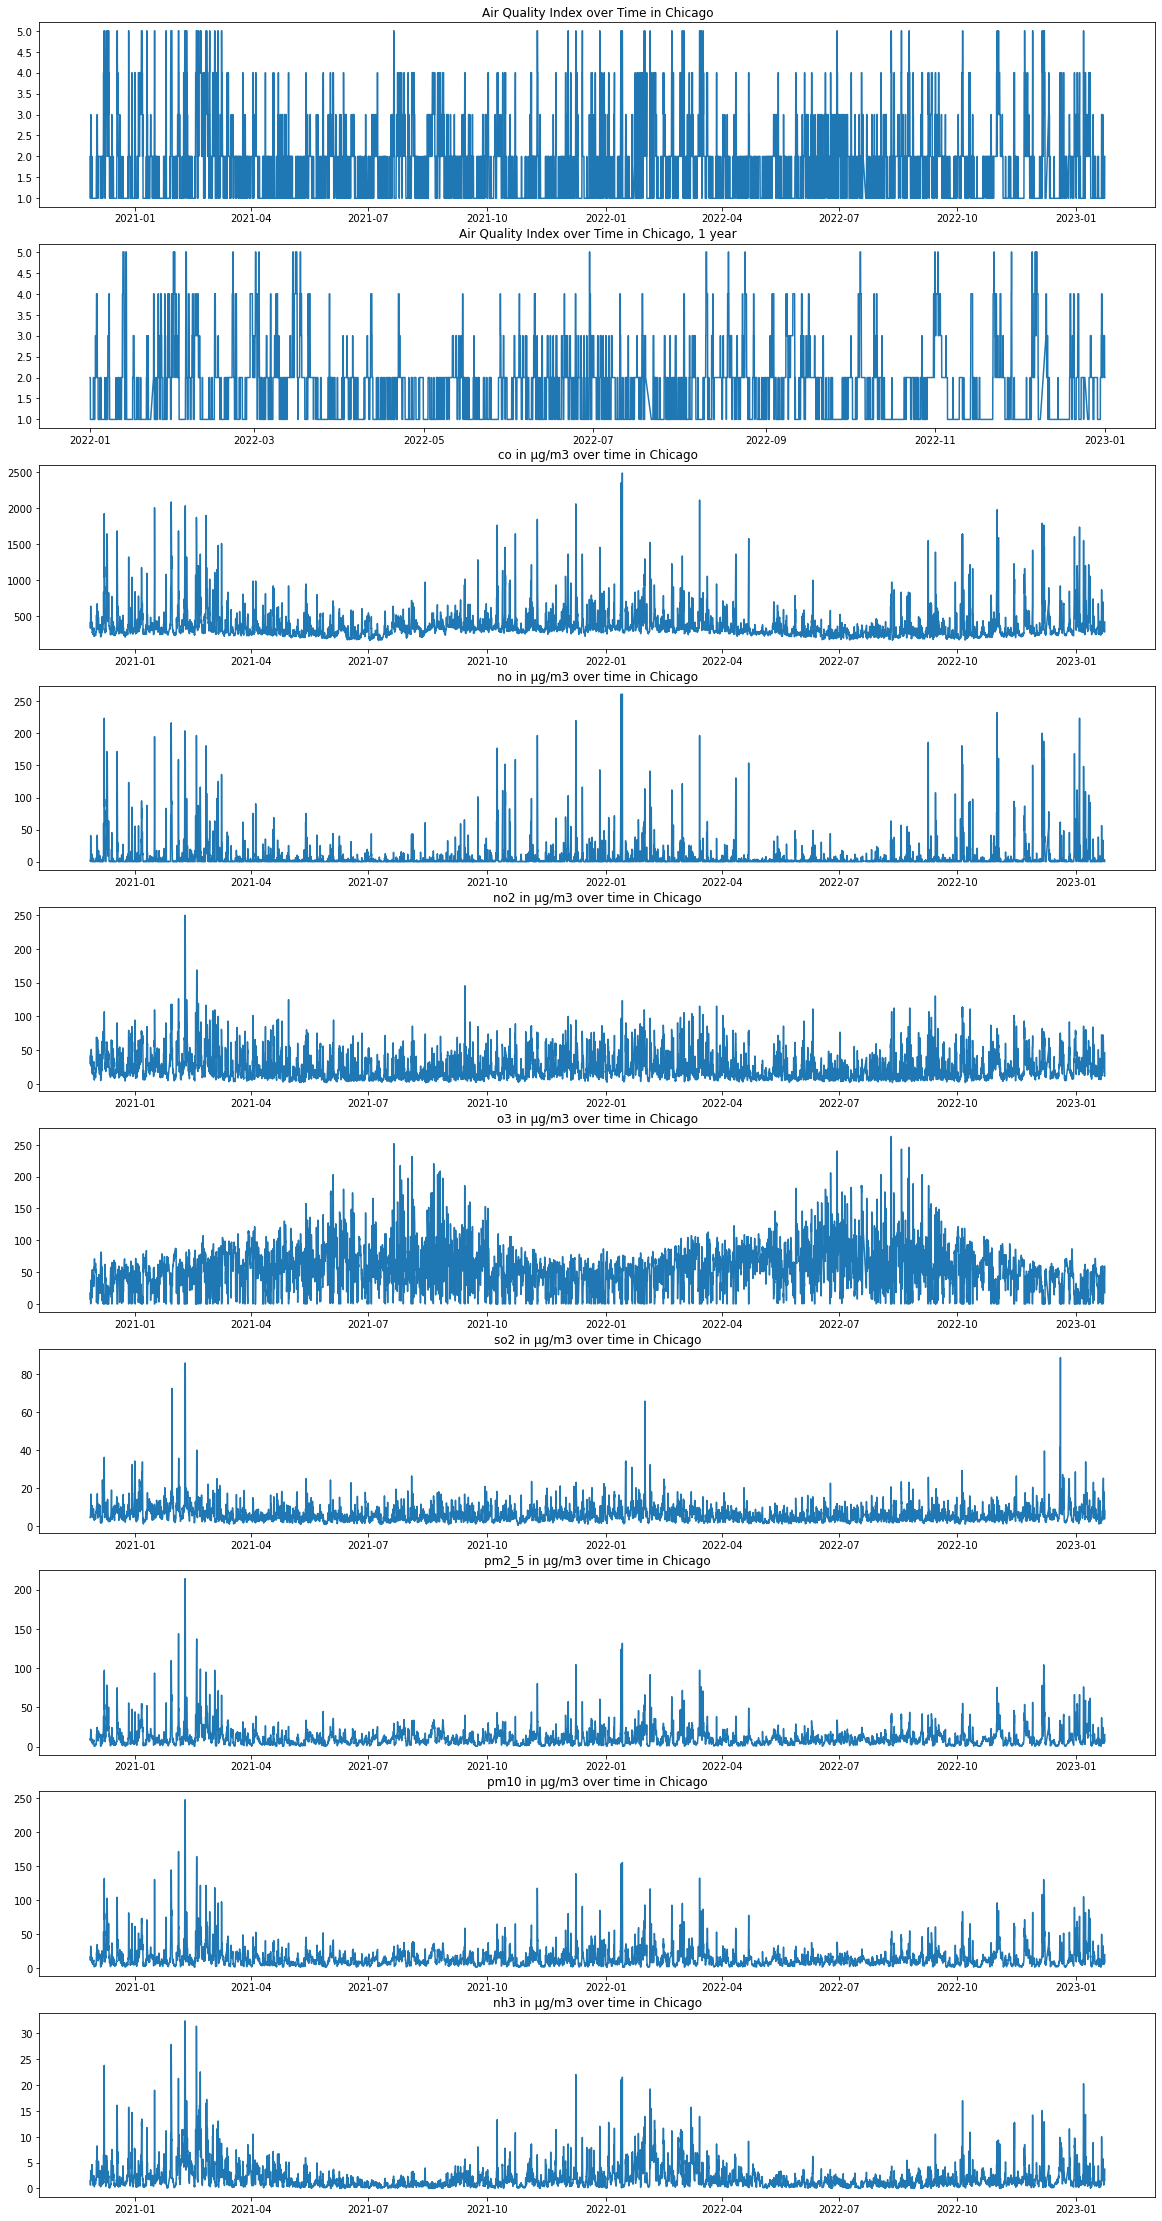

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(10, 1, figsize=(20,40))
ax1[0].plot(data.index, data['aqi'])
ax1[0].set(title='Air Quality Index over Time in Chicago')

year = data.loc[(data.index > '01-01-2022') & (data.index < '01-01-2023')]
ax1[1].plot(year.index, year['aqi'])
ax1[1].set(title='Air Quality Index over Time in Chicago, 1 year')

predictors = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
for i in range(2, 10):
    ax1[i].plot(data.index, data[predictors[i-2]])
    ax1[i].set(title=f'{predictors[i-2]} in μg/m3 over time in Chicago')

From the plots above, we can clearly see that a lot of the pollutants are correlated directly with increases in air quality index (higher numbers are worse). The increases seem to be cyclic, with air quality index increasing in the winter months. However, we can also see that ozone concentrations are also cyclic, but with increases in the summer months. This is due to pollutants reacting with heat and sunlight.

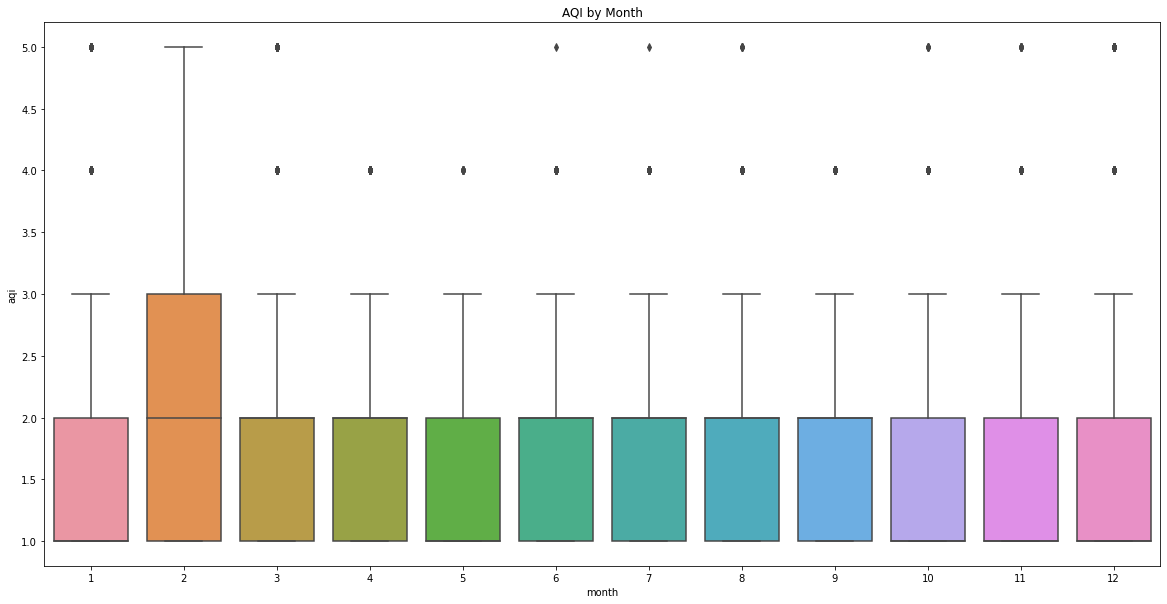

In [6]:
import seaborn as sns

data_with_month = data[['aqi']].copy()
data_with_month['month'] = pd.DatetimeIndex(data_with_month.index).month
fig, ax1 = plt.subplots(figsize=(20,10))
sns.boxplot(data=data_with_month, x='month', y='aqi')
ax1.set(title='AQI by Month')
plt.show()

The boxplot above shows the distribution of AQIs by month in Chicago. Most of the months have a similar distribution of AQIs, which is nice for the people who live there. The air quality is generally pretty good! We *can* see, however, that the outliers in the dataset seem to be concentrated in the winter and summer months. This lines up with the peaks that we see in the time series plots above.

Finally, we can use a rolling average on the data to see if there is an underlying trend:

[Text(0.5, 1.0, 'Weekly Rolling Avg of Chicago AQI')]

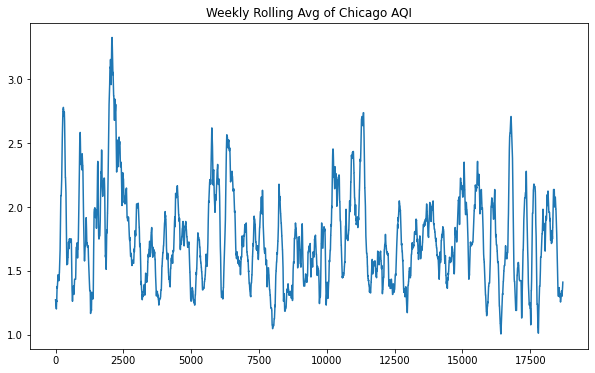

In [7]:
hours = 7*24
rolling_avg = data[['aqi']].rolling(window=hours, center=True, min_periods=int(hours/2)).mean()
rolling_avg

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(range(len(rolling_avg['aqi'])), rolling_avg['aqi'])
ax1.set(title='Weekly Rolling Avg of Chicago AQI')